<a href="https://colab.research.google.com/github/mesuat/social_network_analysis_fraud_detection/blob/master/modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
import random as rnd

import networkx as nx
from networkx.algorithms import bipartite

from collections import Counter
import matplotlib as mpl

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, StandardScaler, RobustScaler
from sklearn.metrics import roc_curve, confusion_matrix, auc, classification_report, accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve

import lightgbm

!pip install node2vec
from node2vec import Node2Vec

import warnings
warnings.filterwarnings('ignore')


!pip install linkpred 
import linkpred

  Stored in directory: /root/.cache/pip/wheels/b3/58/c5/1fff0e4b9b5f90bb5522967f2d08f026d247b9657e70cbf1db
Successfully built node2vec
  Stored in directory: /root/.cache/pip/wheels/6e/75/f1/0d3d7e7f460f5e8cd80a51b55cec6f4d590749142f92a92803
  Stored in directory: /root/.cache/pip/wheels/f5/59/c0/5d73164834188869312f332467cda7431d9eef4ae035583009
Successfully built linkpred smokesignal


In [0]:
link = 'https://drive.google.com/open?id=1FHS82KF_Oh_aQwsf6u2xxMqz_6mfg8oV' # The shareable link

fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1FHS82KF_Oh_aQwsf6u2xxMqz_6mfg8oV


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('project_data.csv')  
df = pd.read_csv('project_data.csv')
# Dataset is now stored in a Pandas Dataframe

In [0]:
df = df.replace("'", "", regex=True)
df.head(2)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,C1093826151,4,M,28007,M348934600,28007,es_transportation,4.55,0
1,0,C352968107,2,M,28007,M348934600,28007,es_transportation,39.68,0


In [0]:
len(df["customer"].unique())

4112

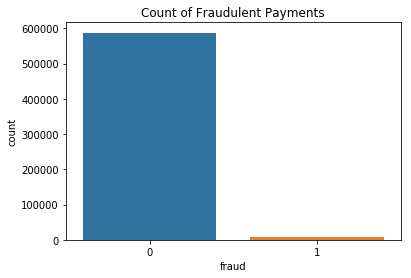

Number of normal examples:  587443
Number of fradulent examples:  7200


In [0]:
# Create two dataframes with fraud and non-fraud data 
df_fraud = df.loc[df.fraud == 1] 
df_non_fraud = df.loc[df.fraud == 0]

sns.countplot(x="fraud",data=df)
plt.title("Count of Fraudulent Payments")
plt.show()
print("Number of normal examples: ",df_non_fraud.fraud.count())
print("Number of fradulent examples: ",df_fraud.fraud.count())
#print(data.fraud.value_counts()) # does the same thing above

No handles with labels found to put in legend.


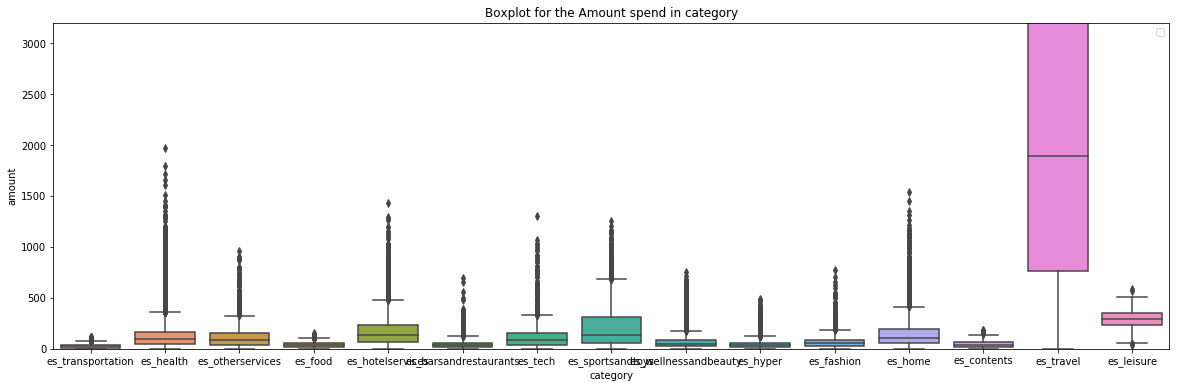

In [0]:
# Plot histograms of the amounts in fraud and non-fraud data 
plt.figure(figsize=(20,6))
sns.boxplot(x=df.category,y=df.amount)
plt.title("Boxplot for the Amount spend in category")
plt.ylim(0,3200)
plt.legend()
plt.show()

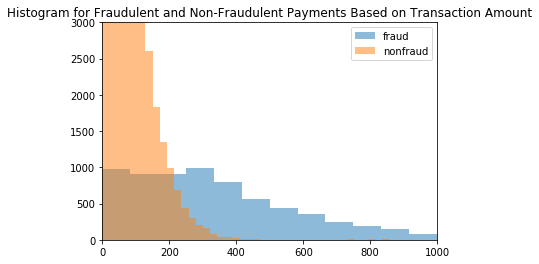

In [0]:
# Plot histograms of the amounts in fraud and non-fraud data 
plt.hist(df_fraud.amount, alpha=0.5, label='fraud',bins=100)
plt.hist(df_non_fraud.amount, alpha=0.5, label='nonfraud',bins=100)
plt.title("Histogram for Fraudulent and Non-Fraudulent Payments Based on Transaction Amount")
plt.ylim(0,3000)
plt.xlim(0,1000)
plt.legend()
plt.show()

In [0]:
cat_col = df.select_dtypes('object').columns.tolist()


In [0]:
cat_col

['customer',
 'age',
 'gender',
 'zipcodeOri',
 'merchant',
 'zipMerchant',
 'category']

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
step           594643 non-null int64
customer       594643 non-null object
age            594643 non-null object
gender         594643 non-null object
zipcodeOri     594643 non-null object
merchant       594643 non-null object
zipMerchant    594643 non-null object
category       594643 non-null object
amount         594643 non-null float64
fraud          594643 non-null int64
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


#Building Model Before SNA

In [0]:
X = df.drop(["fraud", "step"], axis = 1)

In [0]:
y = df.fraud

In [0]:
X.shape

(594643, 8)

In [0]:
X.tail(2)

,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount
594641,C1499363341,5,M,28007,M1823072687,28007,es_transportation,14.46
594642,C616528518,4,F,28007,M1823072687,28007,es_transportation,26.93


In [0]:
X[:297321].tail(2)

,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount
297319,C1971153898,3,M,28007,M1823072687,28007,es_transportation,16.17
297320,C741739992,2,F,28007,M1823072687,28007,es_transportation,44.30


In [0]:
le = LabelEncoder()

for c in cat_col:
  le.fit(X[c])
  X[c] = le.transform(X[c])

##Train-Test Split (%50-%50)

In [0]:
X_train, X_test, y_train, y_test = X[:297321], X[297321:], y[:297321], y[297321:]

In [0]:
sc = StandardScaler()

sc_col = X.select_dtypes(["float64", "int64"]).columns.tolist()

for i in sc_col:
  X_train[i] = sc.fit_transform(np.array(X_train[i]).reshape(-1, 1))
  X_test[i] = sc.transform(np.array(X_test[i]).reshape(-1, 1))

In [0]:
X_train.head(2)

,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount
0,-1.543780,0.737881,1.089111,0.0,0.596312,0.0,0.320166,-0.289548
1,0.606238,-0.758032,1.089111,0.0,0.596312,0.0,0.320166,0.009694


##Train-Validation Split (%80-%20)

In [0]:
X_train, X_val, y_train, y_val = X_train[:237856], X_train[237856:], y_train[:237856], y_train[237856:]

In [0]:
sc = StandardScaler()

sc_col = X.select_dtypes(["float64", "int64"]).columns.tolist()

for i in sc_col:
  X_train[i] = sc.fit_transform(np.array(X_train[i]).reshape(-1, 1))
  X_val[i] = sc.transform(np.array(X_val[i]).reshape(-1, 1))

In [0]:
X_train.head(2)

,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount
0,-1.544853,0.738340,1.090001,0.0,0.564267,0.0,0.318357,-0.280284
1,0.607342,-0.757088,1.090001,0.0,0.564267,0.0,0.318357,0.006009


In [0]:
X_train.shape, X_val.shape, X_test.shape

((237856, 8), (59465, 8), (297322, 8))

In [0]:
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'dart',
    'num_leaves': 63,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0,
    "lambda_l2" : 0.5,
    "lambda_l1" : 0.5,
    "min_gain_to_split" : 0.2
}

In [0]:
train_data = lightgbm.Dataset(X_train, label=y_train, categorical_feature=cat_col)
val_data = lightgbm.Dataset(X_val, label=y_val)

In [0]:
model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=val_data,
                       num_boost_round=500,
                       early_stopping_rounds=100)

[1]	valid_0's auc: 0.971714
[2]	valid_0's auc: 0.978806
[3]	valid_0's auc: 0.984284
[4]	valid_0's auc: 0.983593
[5]	valid_0's auc: 0.983907
[6]	valid_0's auc: 0.983729
[7]	valid_0's auc: 0.984512
[8]	valid_0's auc: 0.986044
[9]	valid_0's auc: 0.985882
[10]	valid_0's auc: 0.985912
[11]	valid_0's auc: 0.985872
[12]	valid_0's auc: 0.98587
[13]	valid_0's auc: 0.985767
[14]	valid_0's auc: 0.985829
[15]	valid_0's auc: 0.985737
[16]	valid_0's auc: 0.985755
[17]	valid_0's auc: 0.985747
[18]	valid_0's auc: 0.985379
[19]	valid_0's auc: 0.985898
[20]	valid_0's auc: 0.986635
[21]	valid_0's auc: 0.986394
[22]	valid_0's auc: 0.986235
[23]	valid_0's auc: 0.986906
[24]	valid_0's auc: 0.986996
[25]	valid_0's auc: 0.987014
[26]	valid_0's auc: 0.987261
[27]	valid_0's auc: 0.987197
[28]	valid_0's auc: 0.987396
[29]	valid_0's auc: 0.987144
[30]	valid_0's auc: 0.987187
[31]	valid_0's auc: 0.987368
[32]	valid_0's auc: 0.98745
[33]	valid_0's auc: 0.987438
[34]	valid_0's auc: 0.987805
[35]	valid_0's auc: 0.987

In [0]:
y_pred = model.predict(X_test)

AUC: 0.988


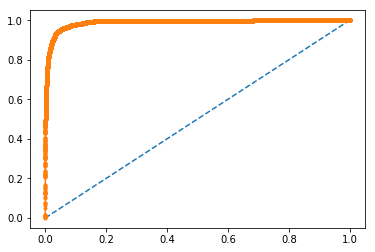

In [0]:
auc = roc_auc_score(y_test, y_pred)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

In [0]:
f1 = {}

for a in [0.90, 0.96, 0.97, 0.98, 0.99]:

  y_pred = model.predict(X_test)

  for i in range(len(y_pred)):
      if y_pred[i]>=a:       
         y_pred[i]=1
      else:  
         y_pred[i]=0
          
  f1[a] = f1_score(y_test, y_pred)
  
print(f1)

{0.9: 0.6269098077870872, 0.96: 0.667576584774037, 0.97: 0.6720404615141458, 0.98: 0.6667756169308711, 0.99: 0.6457450904890258}


In [0]:
fpr[:10], tpr[:10], thresholds[:10]

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.        , 0.00364742, 0.00547112, 0.00577508, 0.00759878,
        0.00790274, 0.00942249, 0.01337386, 0.01398176, 0.01489362]),
 array([1.99914819, 0.99914819, 0.9989553 , 0.99886248, 0.99879666,
        0.99873156, 0.99870207, 0.99852467, 0.99846699, 0.99833729]))

In [0]:
y_pred = model.predict(X_test)

In [0]:
for i in range(len(y_pred)):
    if y_pred[i]>=.97:
       y_pred[i]=1
    else:  
       y_pred[i]=0

In [0]:
confusion_matrix(y_test, y_pred)

array([[293121,    911],
       [  1164,   2126]])

In [0]:
accuracy_score(y_test, y_pred)

0.993021034434048

In [0]:
recall_score(y_test, y_pred)

0.6462006079027356

In [0]:
f1_score(y_test, y_pred)

0.6720404615141458

In [0]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    294032
           1       0.70      0.65      0.67      3290

   micro avg       0.99      0.99      0.99    297322
   macro avg       0.85      0.82      0.83    297322
weighted avg       0.99      0.99      0.99    297322



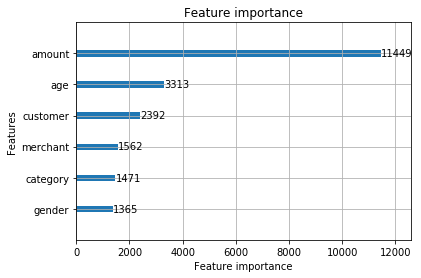

In [0]:
lightgbm.plot_importance(model)

#Using SNA for Credit Card Default Prediction

##Multigraph of Transactions

In [0]:
G_mult = nx.MultiGraph()

for i in range(297321):
    G_mult.add_nodes_from([df["customer"][i]], age = df["age"][i], gender = df["gender"][i], zip_code_cust = df["zipcodeOri"][i], bipartite=0)
    G_mult.add_nodes_from([df["merchant"][i]], zip_code_merc = df["zipMerchant"][i], bipartite=1)
    G_mult.add_edges_from([(df["customer"][i], df["merchant"][i])], amount = df["amount"][i], fraud = df["fraud"][i], step = df["step"][i], category = df["category"][i])

len(G_mult.nodes()), len(G_mult.edges())

(4159, 297321)

In [0]:
nx.is_connected(G_mult)

True

###Calculating SimRank

In [0]:
#const = rnd.uniform(0.45,0.7)
#iter_const = rnd.randint(5,30)


const = 0.6068600098021981
iter_const = 28

simrank = linkpred.predictors.SimRank(G_mult)
simrank_results = simrank.predict(c=const, weight = "fraud", num_iterations = iter_const)

##Graph of Transactions

In [0]:
fraud_edges = df[:297321].groupby(["customer", "merchant"]).sum().reset_index().sort_values(["fraud"], ascending = False)

fraud_edges.head(2)

,customer,merchant,step,amount,fraud
4866,C1275518867,M980657600,1042,10864.97,32
14344,C1849046345,M480139044,864,8658.00,24


In [0]:
fraud_cust = df[:297321].groupby(["customer"]).sum().reset_index().sort_values(["fraud"], ascending = False)

fraud_cust.head(2)

,customer,step,amount,fraud
614,C1275518867,6889,43961.11,97
1836,C1849046345,3798,38364.68,89


In [0]:
fraud_merc = df[:297321].groupby(["merchant"]).sum().reset_index().sort_values(["fraud"], ascending = False)

fraud_merc.head(2)

,merchant,step,amount,fraud
34,M480139044,101625,501473.46,884
49,M980657600,49347,313513.48,850


In [0]:
cust_fraud_dic = {}

for index, row in fraud_cust.iterrows():
  cust_fraud_dic[fraud_cust["customer"][index]] = fraud_cust["fraud"][index]

In [0]:
merc_fraud_dic = {}

for index, row in fraud_merc.iterrows():
  merc_fraud_dic[fraud_merc["merchant"][index]] = fraud_merc["fraud"][index]

In [0]:
G = nx.Graph()

#G = nx.from_pandas_edgelist(df, "customer", "merchant",["step", "amount", "fraud"])


for i in range(297321):
    G.add_nodes_from([df["customer"][i]], age = df["age"][i], gender = df["gender"][i], zip_code_cust = df["zipcodeOri"][i], bipartite=0)
    G.add_nodes_from([df["merchant"][i]], zip_code_merc = df["zipMerchant"][i], bipartite=1)     

for j in range(len(fraud_edges)):
  G.add_edges_from([(fraud_edges["customer"][j], fraud_edges["merchant"][j])], fraud = fraud_edges["fraud"][j])

In [0]:
len(G.nodes()), len(G.edges())

(4159, 31887)

In [0]:
nx.is_connected(G)

True

###Calculating Association Strength, Common Neighbors, Degree Product, Jaccard, Max Overlap, Min Overlap, Pearson, Resource Allocation Algorthms

In [0]:
assoc_str = linkpred.predictors.AssociationStrength(G)
assoc_str_results = assoc_str.predict(weight = "fraud")

In [0]:
comm = linkpred.predictors.CommonNeighbours(G)
comm_results = comm.predict(weight = "fraud")

In [0]:
degr_prod = linkpred.predictors.DegreeProduct(G)
degr_prod_results = degr_prod.predict(weight = "fraud")

In [0]:
jac = linkpred.predictors.Jaccard(G)
jac_results = jac.predict(weight = "fraud")

In [0]:
max_lap = linkpred.predictors.MaxOverlap(G)
max_lap_results = max_lap.predict(weight = "fraud")

In [0]:
min_lap = linkpred.predictors.MinOverlap(G)
min_lap_results = min_lap.predict(weight = "fraud")

In [0]:
pear = linkpred.predictors.Pearson(G)
pear_results = pear.predict(weight = "fraud")

In [0]:
customers, merchants = bipartite.sets(G_mult)

In [0]:
len(merchants), len(customers)

(50, 4109)

In [0]:
len(G.nodes()), len(G.edges())

(4159, 31887)

In [0]:
nx.is_bipartite(G)

True

In [0]:
cust_proj = bipartite.weighted_projected_graph(G, customers)

In [0]:
merc_proj = bipartite.weighted_projected_graph(G, merchants)

In [0]:
len(cust_proj), len(merc_proj)

(4109, 50)

In [0]:
cust_proj_list = list(cust_proj.edges()(data = True))

In [0]:
merc_proj_list = list(merc_proj.edges()(data = True))

In [0]:
selected_cust = []

for i in range(len(cust_proj_list)):
  if cust_proj_list[i][2]["weight"] > 6:
    selected_cust += [(cust_proj_list[i][0], cust_proj_list[i][1], cust_proj_list[i][2])]

In [0]:
selected_merc = []

for i in range(len(merc_proj_list)):
  if merc_proj_list[i][2]["weight"] > 2:
    selected_merc += [(merc_proj_list[i][0], merc_proj_list[i][1], merc_proj_list[i][2])]

In [0]:
len(selected_cust), len(selected_merc)

(371038, 1020)

In [0]:
selected_merc_graph = nx.Graph(selected_merc)

In [0]:
selected_cust_graph = nx.Graph(selected_cust)

In [0]:
len(selected_cust), len(selected_merc), len(selected_cust_graph.nodes()), len(selected_merc_graph.nodes())

(371038, 1020, 2809, 49)

In [0]:
personalization_cust = cust_fraud_dic

In [0]:
personalization_merc = merc_fraud_dic

###Calculating Personalized PageRank Based on Bipartite Networks

In [0]:
pr_merc = dict(nx.pagerank(selected_merc_graph, alpha=0.85, personalization=personalization_merc))

sorted_pr_merc = sorted(pr_merc.items(), key=lambda kv: -kv[1])

print(sorted_pr_merc)

[('M348934600', 0.08354552233367382), ('M480139044', 0.06710436122805753), ('M855959430', 0.06459684282170805), ('M1823072687', 0.0645619534226022), ('M85975013', 0.057202493549817), ('M151143676', 0.05620185253008643), ('M980657600', 0.05099266546521843), ('M209847108', 0.043886136514010105), ('M1053599405', 0.03930410583273517), ('M1946091778', 0.035712934851047186), ('M1198415165', 0.03205146794161712), ('M1535107174', 0.030039077369058257), ('M1600850729', 0.02957072298491687), ('M349281107', 0.021900019873773092), ('M1888755466', 0.021211544656175398), ('M732195782', 0.020517938097396306), ('M1649169323', 0.020257138139319883), ('M840466850', 0.018735481901886238), ('M547558035', 0.018625746561555752), ('M1913465890', 0.017617567027741112), ('M78078399', 0.01632826707546936), ('M1741626453', 0.01614988001195423), ('M50039827', 0.01603878929338534), ('M692898500', 0.01422991756888635), ('M3697346', 0.011585045749362794), ('M2122776122', 0.011430385072711768), ('M1842530320', 0.0110

In [0]:
pr_cust = dict(nx.pagerank_numpy(selected_cust_graph, alpha=0.85, personalization=personalization_cust))

sorted_pr_cust = sorted(pr_cust.items(), key=lambda kv: -kv[1])

print(sorted_pr_cust)

[('C1275518867', 0.011624063801615046), ('C1978250683', 0.010202710496320181), ('C1849046345', 0.008606087497087663), ('C806399525', 0.007748230037911436), ('C1572610482', 0.006746578508803942), ('C1175850429', 0.006250968881330931), ('C1350963410', 0.006030298297820652), ('C1079254393', 0.0055254993437973045), ('C218446443', 0.005421448193631933), ('C811312110', 0.00521341526947183), ('C2004941826', 0.0051240073125358165), ('C515668508', 0.0051136899966422724), ('C1464489812', 0.004934808530728009), ('C1312615175', 0.004790972074141397), ('C2113737065', 0.004056150970669735), ('C910454738', 0.004016331618325708), ('C1685492470', 0.0036799064501528483), ('C1728122351', 0.0035484870234824893), ('C1817318774', 0.0034874955982012695), ('C587299231', 0.0031138495738662468), ('C1994736634', 0.0030925573087122013), ('C1143401925', 0.002956615841059092), ('C1994178184', 0.002857225997397819), ('C1777502922', 0.002835832273063597), ('C1653588482', 0.0027688373283616123), ('C553434543', 0.00272

###Calculating degree with MultiGraph with Weights (Fraud)

In [0]:
degree = dict(nx.degree(G_mult, weight = "fraud"))

###Calculating EigenVector Centrality with MultiGraph with Weights (Fraud)

In [0]:
eig_cent = dict(nx.eigenvector_centrality_numpy(G_mult, weight = "fraud"))

###Calculating Betweenness Centrality with MultiGraph with Weights (Fraud)

In [0]:
betw_cent = dict(nx.betweenness_centrality(G_mult, weight = "fraud"))

##Train-Test Split (50%-50%)

In [0]:
X_sna = df.drop(["fraud", "step"], axis = 1)

In [0]:
y_sna = df.fraud

In [0]:
X_sna["cust_merc_comb"] = list(zip(X_sna.customer, X_sna.merchant))

###Apply Weighted Degree, Centrality Measures, Personalized PageRank Score



In [0]:
X_sna["degree_merc"] = X_sna.merchant.map(degree)
X_sna["degree_cust"] = X_sna.customer.map(degree)

X_sna["betw_cent_merc"] = X_sna.merchant.map(betw_cent)
X_sna["betw_cent_cust"] = X_sna.customer.map(betw_cent)

X_sna["eig_cent_merc"] = X_sna.merchant.map(eig_cent)
X_sna["eig_cent_cust"] = X_sna.customer.map(eig_cent)

X_sna["pr_cust"] = X_sna.customer.map(pr_cust)
X_sna["pr_merc"] = X_sna.merchant.map(pr_merc)

###Apply SimRank, Association Strength, Common Neighbors, Degree Product, Jaccard, Max Overlap, Min Overlap, Pearson, Resource Allocation Algorithms

In [0]:
X_sna["Simrank"] = X_sna["cust_merc_comb"].map(simrank_results)
X_sna["Assoc_Stren"] = X_sna["cust_merc_comb"].map(assoc_str_results)
X_sna["Comm_Neigh"] = X_sna["cust_merc_comb"].map(comm_results)
X_sna["Degr_Prod"] = X_sna["cust_merc_comb"].map(degr_prod_results)
X_sna["Jaccard"] = X_sna["cust_merc_comb"].map(jac_results)
X_sna["Max_Over_Lap"] = X_sna["cust_merc_comb"].map(max_lap_results)
X_sna["Min_Over_Lap"] = X_sna["cust_merc_comb"].map(min_lap_results)
X_sna["Pearson"] = X_sna["cust_merc_comb"].map(pear_results)

In [0]:
X_sna.head(2)

,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,cust_merc_comb,degree_merc,degree_cust,betw_cent_merc,betw_cent_cust,eig_cent_merc,eig_cent_cust,pr_cust,pr_merc,Simrank,Assoc_Stren,Comm_Neigh,Degr_Prod,Jaccard,Max_Over_Lap,Min_Over_Lap,Pearson
0,C1093826151,4,M,28007,M348934600,28007,es_transportation,4.55,"(C1093826151, M348934600)",0,0.0,0.296889,0.000003,-2.882246e-21,-1.320560e-18,NaN,0.083546,0.000166,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,C352968107,2,M,28007,M348934600,28007,es_transportation,39.68,"(C352968107, M348934600)",0,0.0,0.296889,0.000017,-2.882246e-21,7.109528e-18,0.000332,0.083546,0.000166,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
X_sna.isnull().sum()

customer               0
age                    0
gender                 0
zipcodeOri             0
merchant               0
zipMerchant            0
category               0
amount                 0
cust_merc_comb         0
degree_merc            0
degree_cust           86
betw_cent_merc         0
betw_cent_cust        86
eig_cent_merc          0
eig_cent_cust         86
pr_cust           167651
pr_merc                3
Simrank                0
Assoc_Stren            0
Comm_Neigh             0
Degr_Prod              0
Jaccard                0
Max_Over_Lap           0
Min_Over_Lap           0
Pearson                0
dtype: int64

In [0]:
X_sna.fillna(0, inplace = True)

In [0]:
X_sna.dtypes

customer           object
age                object
gender             object
zipcodeOri         object
merchant           object
zipMerchant        object
category           object
amount            float64
cust_merc_comb     object
degree_merc         int64
degree_cust       float64
betw_cent_merc    float64
betw_cent_cust    float64
eig_cent_merc     float64
eig_cent_cust     float64
pr_cust           float64
pr_merc           float64
Simrank           float64
Assoc_Stren       float64
Comm_Neigh        float64
Degr_Prod         float64
Jaccard           float64
Max_Over_Lap      float64
Min_Over_Lap      float64
Pearson           float64
dtype: object

In [0]:
X_sna.drop("cust_merc_comb", axis = 1, inplace = True)

In [0]:
#X_sna["cust_merc_comb"] = X_sna["cust_merc_comb"].astype(str)

In [0]:
cat_col = X_sna.select_dtypes('object').columns.tolist()

le = LabelEncoder()

for c in cat_col:
  le.fit(X_sna[c])
  X_sna[c] = le.transform(X_sna[c])

In [0]:
X_train_sna, X_test_sna, y_train_sna, y_test_sna = X_sna[:297321], X_sna[297321:], y_sna[:297321], y_sna[297321:]

In [0]:
X_train_sna.shape, X_test_sna.shape

((297321, 24), (297322, 24))

In [0]:
X_train_sna.head(2)

,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,degree_merc,degree_cust,betw_cent_merc,betw_cent_cust,eig_cent_merc,eig_cent_cust,pr_cust,pr_merc,Simrank,Assoc_Stren,Comm_Neigh,Degr_Prod,Jaccard,Max_Over_Lap,Min_Over_Lap,Pearson
0,210,4,2,0,30,0,12,4.55,0,0.0,0.296889,0.000003,-2.882246e-21,-1.320560e-18,0.000000,0.083546,0.000166,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2753,2,2,0,30,0,12,39.68,0,0.0,0.296889,0.000017,-2.882246e-21,7.109528e-18,0.000332,0.083546,0.000166,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
sc = StandardScaler()

sc_col = X_sna.select_dtypes(["float64", "int64"]).columns.tolist()

for i in sc_col:
  X_train_sna[i] = sc.fit_transform(np.array(X_train_sna[i]).reshape(-1, 1))
  X_test_sna[i] = sc.transform(np.array(X_test_sna[i]).reshape(-1, 1))

##Train-Validation Split (80%-20%)

In [0]:
X_train_sna, X_val_sna, y_train_sna, y_val_sna = X_train_sna[:237856], X_train_sna[237856:], y_train_sna[:237856], y_train_sna[237856:]

In [0]:
X_val_sna.shape

(59465, 24)

In [0]:
sc = StandardScaler()

sc_col = X.select_dtypes(["float64", "int64"]).columns.tolist()

for i in sc_col:
  X_train_sna[i] = sc.fit_transform(np.array(X_train_sna[i]).reshape(-1, 1))
  X_val_sna[i] = sc.transform(np.array(X_val_sna[i]).reshape(-1, 1))

In [0]:
X_train_sna.shape, X_val_sna.shape, X_test_sna.shape

((237856, 24), (59465, 24), (297322, 24))

In [0]:
X_train_sna.head(4)

,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,degree_merc,degree_cust,betw_cent_merc,betw_cent_cust,eig_cent_merc,eig_cent_cust,pr_cust,pr_merc,Simrank,Assoc_Stren,Comm_Neigh,Degr_Prod,Jaccard,Max_Over_Lap,Min_Over_Lap,Pearson
0,-1.544853,0.738340,1.090001,0.0,0.564267,0.0,0.318357,-0.280284,-0.166343,-0.162225,1.058713,-0.551070,-0.152374,-0.150719,-0.423646,0.846476,-0.07135,0.0,0.0,-0.041098,0.0,0.0,0.0,0.0
1,0.607342,-0.757088,1.090001,0.0,0.564267,0.0,0.318357,0.006009,-0.166343,-0.162225,1.058713,-0.274292,-0.152374,-0.150719,0.137836,0.846476,-0.07135,0.0,0.0,-0.041098,0.0,0.0,0.0,0.0
2,0.211264,0.738340,-0.897651,0.0,-0.872640,0.0,0.318357,-0.098224,-0.166343,-0.162225,-0.664743,2.944750,-0.152374,-0.150719,1.312838,-0.314713,-0.07135,0.0,0.0,-0.041098,0.0,0.0,0.0,0.0
3,-0.326150,-0.009374,1.090001,0.0,0.564267,0.0,0.318357,-0.176785,-0.166343,-0.162225,1.058713,-0.457988,-0.152374,-0.150719,-0.214287,0.846476,-0.07135,0.0,0.0,-0.041098,0.0,0.0,0.0,0.0


In [0]:
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'dart',
    'num_leaves': 63,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0,
    "lambda_l2" : 0.5,
    "lambda_l1" : 0.5,
    "min_gain_to_split" : 0.2,
    "max_depth" : 3
}

In [0]:
train_data_sna = lightgbm.Dataset(X_train_sna, label=y_train_sna, categorical_feature=cat_col)
val_data_sna = lightgbm.Dataset(X_val_sna, label=y_val_sna)

In [0]:
model_sna = lightgbm.train(parameters,
                       train_data_sna,
                       valid_sets=val_data_sna,
                       num_boost_round=500,
                       early_stopping_rounds=100)

[1]	valid_0's auc: 0.99595
[2]	valid_0's auc: 0.997414
[3]	valid_0's auc: 0.997945
[4]	valid_0's auc: 0.99822
[5]	valid_0's auc: 0.998228
[6]	valid_0's auc: 0.998227
[7]	valid_0's auc: 0.998227
[8]	valid_0's auc: 0.998228
[9]	valid_0's auc: 0.998395
[10]	valid_0's auc: 0.998582
[11]	valid_0's auc: 0.998658
[12]	valid_0's auc: 0.998634
[13]	valid_0's auc: 0.99869
[14]	valid_0's auc: 0.99871
[15]	valid_0's auc: 0.998747
[16]	valid_0's auc: 0.998756
[17]	valid_0's auc: 0.998769
[18]	valid_0's auc: 0.998781
[19]	valid_0's auc: 0.998879
[20]	valid_0's auc: 0.998893
[21]	valid_0's auc: 0.998894
[22]	valid_0's auc: 0.998895
[23]	valid_0's auc: 0.998895
[24]	valid_0's auc: 0.998884
[25]	valid_0's auc: 0.998898
[26]	valid_0's auc: 0.998884
[27]	valid_0's auc: 0.998884
[28]	valid_0's auc: 0.998882
[29]	valid_0's auc: 0.998882
[30]	valid_0's auc: 0.998894
[31]	valid_0's auc: 0.998892
[32]	valid_0's auc: 0.998922
[33]	valid_0's auc: 0.998971
[34]	valid_0's auc: 0.998991
[35]	valid_0's auc: 0.99900

In [0]:
y_pred_sna = model_sna.predict(X_test_sna)

AUC: 0.996


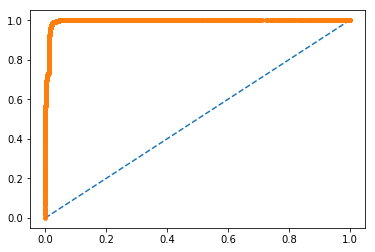

In [0]:
auc = roc_auc_score(y_test_sna, y_pred_sna)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test_sna, y_pred_sna)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

In [0]:
fpr[:10], tpr[:10], thresholds[:10]

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.        , 0.00030395, 0.0006079 , 0.00121581, 0.00212766,
        0.00334347, 0.00364742, 0.00607903, 0.01550152, 0.01671733]),
 array([1.99952887, 0.99952887, 0.99950164, 0.99948272, 0.99947696,
        0.99947576, 0.99947121, 0.99943416, 0.99941614, 0.99940679]))

In [0]:
f1 = {}

for a in [0.90, 0.95, 0.96, 0.97, 0.98, 0.99]:

  y_pred_sna = model_sna.predict(X_test_sna)

  for i in range(len(y_pred_sna)):
      if y_pred_sna[i]>=a:       
         y_pred_sna[i]=1
      else:  
         y_pred_sna[i]=0
          
  f1[a]= f1_score(y_test_sna, y_pred_sna)
  
print(f1)

{0.9: 0.7127590673575129, 0.95: 0.7176917760884589, 0.96: 0.715444287729196, 0.97: 0.7108542532057072, 0.98: 0.6935849056603773, 0.99: 0.642120169937285}


In [0]:
y_pred_sna = model_sna.predict(X_test_sna)

In [0]:
for i in range(len(y_pred_sna)):
    if y_pred_sna[i]>=0.95:      
       y_pred_sna[i]=1
    else:  
       y_pred_sna[i]=0

In [0]:
confusion_matrix(y_test_sna, y_pred_sna)

array([[293611,    421],
       [  1213,   2077]])

In [0]:
accuracy_score(y_test_sna, y_pred_sna)

0.994504274826619

In [0]:
recall_score(y_test_sna, y_pred_sna)

0.6313069908814589

In [0]:
f1_score(y_test_sna, y_pred_sna)

0.7176917760884589

In [0]:
print(classification_report(y_test_sna, y_pred_sna))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    294032
           1       0.83      0.63      0.72      3290

   micro avg       0.99      0.99      0.99    297322
   macro avg       0.91      0.81      0.86    297322
weighted avg       0.99      0.99      0.99    297322



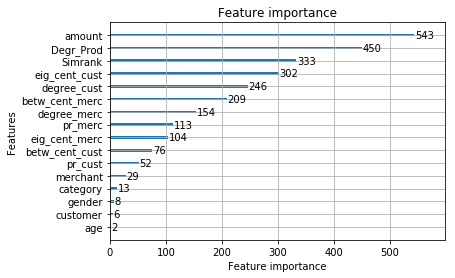

In [0]:
lightgbm.plot_importance(model_sna)

##Train-Test Split (50%-50%)

In [0]:
X_sna = df.drop(["fraud", "step"], axis = 1)

In [0]:
y_sna = df.fraud

In [0]:
X_sna["cust_merc_comb"] = list(zip(X_sna.customer, X_sna.merchant))

###Apply SimRank Algorithm

In [0]:
X_sna["Simrank"] = X_sna["cust_merc_comb"].map(simrank_results)

In [0]:
X_sna.head(2)

,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,cust_merc_comb,Simrank
0,C1093826151,4,M,28007,M348934600,28007,es_transportation,4.55,"(C1093826151, M348934600)",0.000166
1,C352968107,2,M,28007,M348934600,28007,es_transportation,39.68,"(C352968107, M348934600)",0.000166


In [0]:
X_sna.isnull().sum()

customer          0
age               0
gender            0
zipcodeOri        0
merchant          0
zipMerchant       0
category          0
amount            0
cust_merc_comb    0
Simrank           0
dtype: int64

In [0]:
X_sna.fillna(0, inplace = True)

In [0]:
X_sna.dtypes

customer           object
age                object
gender             object
zipcodeOri         object
merchant           object
zipMerchant        object
category           object
amount            float64
cust_merc_comb     object
Simrank           float64
dtype: object

In [0]:
X_sna.drop("cust_merc_comb", axis = 1, inplace = True)

In [0]:
#X_sna["cust_merc_comb"] = X_sna["cust_merc_comb"].astype(str)

In [0]:
cat_col = X_sna.select_dtypes('object').columns.tolist()

le = LabelEncoder()

for c in cat_col:
  le.fit(X_sna[c])
  X_sna[c] = le.transform(X_sna[c])

In [0]:
X_train_sna, X_test_sna, y_train_sna, y_test_sna = X_sna[:297321], X_sna[297321:], y_sna[:297321], y_sna[297321:]

In [0]:
X_train_sna.shape, X_test_sna.shape

((297321, 9), (297322, 9))

In [0]:
X_train_sna.head(2)

,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,Simrank
0,210,4,2,0,30,0,12,4.55,0.000166
1,2753,2,2,0,30,0,12,39.68,0.000166


In [0]:
sc = StandardScaler()

sc_col = X_sna.select_dtypes(["float64", "int64"]).columns.tolist()

for i in sc_col:
  X_train_sna[i] = sc.fit_transform(np.array(X_train_sna[i]).reshape(-1, 1))
  X_test_sna[i] = sc.transform(np.array(X_test_sna[i]).reshape(-1, 1))

##Train-Validation Split (80%-20%)

In [0]:
X_train_sna, X_val_sna, y_train_sna, y_val_sna = X_train_sna[:237856], X_train_sna[237856:], y_train_sna[:237856], y_train_sna[237856:]

In [0]:
X_val_sna.shape

(59465, 9)

In [0]:
sc = StandardScaler()

sc_col = X.select_dtypes(["float64", "int64"]).columns.tolist()

for i in sc_col:
  X_train_sna[i] = sc.fit_transform(np.array(X_train_sna[i]).reshape(-1, 1))
  X_val_sna[i] = sc.transform(np.array(X_val_sna[i]).reshape(-1, 1))

In [0]:
X_train_sna.shape, X_val_sna.shape, X_test_sna.shape

((237856, 9), (59465, 9), (297322, 9))

In [0]:
X_train_sna.head(4)

,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,Simrank
0,-1.544853,0.738340,1.090001,0.0,0.564267,0.0,0.318357,-0.280284,-0.07135
1,0.607342,-0.757088,1.090001,0.0,0.564267,0.0,0.318357,0.006009,-0.07135
2,0.211264,0.738340,-0.897651,0.0,-0.872640,0.0,0.318357,-0.098224,-0.07135
3,-0.326150,-0.009374,1.090001,0.0,0.564267,0.0,0.318357,-0.176785,-0.07135


In [0]:
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'dart',
    'num_leaves': 63,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0,
    "lambda_l2" : 0.5,
    "lambda_l1" : 0.5,
    "min_gain_to_split" : 0.2,
    "max_depth" : 3
}

In [0]:
train_data_sna = lightgbm.Dataset(X_train_sna, label=y_train_sna, categorical_feature=cat_col)
val_data_sna = lightgbm.Dataset(X_val_sna, label=y_val_sna)

In [0]:
model_sna = lightgbm.train(parameters,
                       train_data_sna,
                       valid_sets=val_data_sna,
                       num_boost_round=500,
                       early_stopping_rounds=100)

[1]	valid_0's auc: 0.955742
[2]	valid_0's auc: 0.983836
[3]	valid_0's auc: 0.985896
[4]	valid_0's auc: 0.986321
[5]	valid_0's auc: 0.987458
[6]	valid_0's auc: 0.987979
[7]	valid_0's auc: 0.988267
[8]	valid_0's auc: 0.987906
[9]	valid_0's auc: 0.988943
[10]	valid_0's auc: 0.989742
[11]	valid_0's auc: 0.989976
[12]	valid_0's auc: 0.989615
[13]	valid_0's auc: 0.989802
[14]	valid_0's auc: 0.989966
[15]	valid_0's auc: 0.990616
[16]	valid_0's auc: 0.991153
[17]	valid_0's auc: 0.991205
[18]	valid_0's auc: 0.991191
[19]	valid_0's auc: 0.991657
[20]	valid_0's auc: 0.991732
[21]	valid_0's auc: 0.991596
[22]	valid_0's auc: 0.991593
[23]	valid_0's auc: 0.991597
[24]	valid_0's auc: 0.991734
[25]	valid_0's auc: 0.991834
[26]	valid_0's auc: 0.99191
[27]	valid_0's auc: 0.991907
[28]	valid_0's auc: 0.991784
[29]	valid_0's auc: 0.991856
[30]	valid_0's auc: 0.992191
[31]	valid_0's auc: 0.992142
[32]	valid_0's auc: 0.992342
[33]	valid_0's auc: 0.993249
[34]	valid_0's auc: 0.993209
[35]	valid_0's auc: 0.99

In [0]:
y_pred_sna = model_sna.predict(X_test_sna)

AUC: 0.998


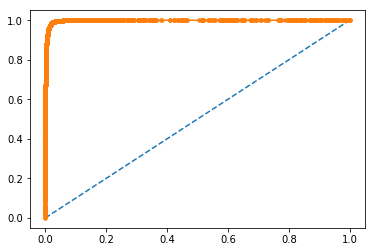

In [0]:
auc = roc_auc_score(y_test_sna, y_pred_sna)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test_sna, y_pred_sna)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

In [0]:
fpr[:10], tpr[:10], thresholds[:10]

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.        , 0.00030395, 0.0006079 , 0.00273556, 0.00334347,
        0.00395137, 0.00455927, 0.01276596, 0.01306991, 0.01367781]),
 array([1.99900056, 0.99900056, 0.99898407, 0.99893916, 0.99892166,
        0.99889171, 0.99889061, 0.99888489, 0.99887342, 0.99887068]))

In [0]:
f1 = {}

for a in [0.6, 0.7, 0.75, 0.8, 0.85, 0.90, 0.95]:

  y_pred_sna = model_sna.predict(X_test_sna)

  for i in range(len(y_pred_sna)):
      if y_pred_sna[i]>=a:       
         y_pred_sna[i]=1
      else:  
         y_pred_sna[i]=0
          
  f1[a]= f1_score(y_test_sna, y_pred_sna)
  
print(f1)

{0.6: 0.6894382022471911, 0.7: 0.7294854801783347, 0.75: 0.7495272910626497, 0.8: 0.7734674963590625, 0.85: 0.7972222222222223, 0.9: 0.821608785989908, 0.95: 0.8034748401901327}


In [0]:
y_pred_sna = model_sna.predict(X_test_sna)

In [0]:
for i in range(len(y_pred_sna)):
    if y_pred_sna[i]>=0.9:      
       y_pred_sna[i]=1
    else:  
       y_pred_sna[i]=0

In [0]:
confusion_matrix(y_test_sna, y_pred_sna)

array([[293352,    680],
       [   522,   2768]])

In [0]:
accuracy_score(y_test_sna, y_pred_sna)

0.9959572450070967

In [0]:
recall_score(y_test_sna, y_pred_sna)

0.841337386018237

In [0]:
f1_score(y_test_sna, y_pred_sna)

0.821608785989908

In [0]:
print(classification_report(y_test_sna, y_pred_sna))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    294032
           1       0.80      0.84      0.82      3290

   micro avg       1.00      1.00      1.00    297322
   macro avg       0.90      0.92      0.91    297322
weighted avg       1.00      1.00      1.00    297322



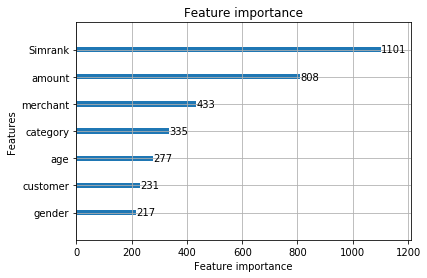

In [0]:
lightgbm.plot_importance(model_sna)

#Report

In [0]:
G_mult_report = nx.MultiGraph()

for i in range(len(df)):
    G_mult_report.add_nodes_from([df["customer"][i]], age = df["age"][i], gender = df["gender"][i], zip_code_cust = df["zipcodeOri"][i], bipartite=0)
    G_mult_report.add_nodes_from([df["merchant"][i]], zip_code_merc = df["zipMerchant"][i], bipartite=1)
    G_mult_report.add_edges_from([(df["customer"][i], df["merchant"][i])], amount = df["amount"][i], fraud = df["fraud"][i], step = df["step"][i], category = df["category"][i])

len(G_mult_report.nodes()), len(G_mult_report.edges())

In [0]:
print("Number of edges:", len(G_mult_report.edges()))

In [0]:
print("Number of nodes:", len(G_mult_report.nodes()))

In [0]:
tot_deg = 0
for i in range(len(list(G_mult_report.degree))):
    tot_deg += list(G_mult_report.degree)[i][1]

av_deg = tot_deg / len(G_mult_report.nodes())
print("Average Degree:", av_deg)


In [0]:
plt.title("Degree Distribution")
plt.hist(list(dict(nx.degree(G_mult_report)).values()))
plt.show()


In [0]:
degree_sequence=sorted(dict(G_mult_report.degree()).values(),reverse=True)
dmax=max(degree_sequence)

plt.loglog(degree_sequence,'b-',marker='o')
plt.title("Loglog Degree Distribution")
plt.ylabel("degree")
plt.xlabel("rank")
plt.show()

In [0]:
G_report = nx.Graph()


for i in range(len(df)):
    G_report.add_nodes_from([df["customer"][i]], age = df["age"][i], gender = df["gender"][i], zip_code_cust = df["zipcodeOri"][i], bipartite=0)
    G_report.add_nodes_from([df["merchant"][i]], zip_code_merc = df["zipMerchant"][i], bipartite=1)     


len(G_report.nodes()), len(G_report.edges())

In [0]:
print("Diameter of the network")
print(nx.diameter(G_mult_report))
